In [55]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 10 10:59:39 2019

@author: Katherine, Ki Wan
"""

import csv
import os
from functools import partial
import json
import numpy as np
import geopandas as gpd
import matplotlib

import matplotlib.pyplot as plt
#import seaborn as sns
import networkx as nx
import random


from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept



In [60]:
num_districts = 14
output_dirname = "Run_1"

newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")
    
graph = Graph.from_json("./data/ga_tract.json")
df = gpd.read_file("./data/ga_2012_tract.gpkg")


In [73]:
# SUMMING DATA WE WANT IN THE DATAFRAME

new_cols = ['CPOP', 'VAP', 'BVAP', 'nVAP', 'CVAP', 'BCVAP', 'nBCVAP']

VAP_cols = ['MVAPTotal', 'FVAPTotal']
BVAP_cols = ['MVAPBLACK', 'FVAPBLACK']
CVAP_cols = ['MNativeBornVAPTotal', 'MNaturalizedVAPTotal', 'FNativeBornVAPTotal', 'FNaturalizedVAPTotal']
BCVAP_cols = ['MNativeBornVAPBLACK', 'MNaturalizedVAPBLACK', 'FNativeBornVAPBLACK', 'FNaturalizedVAPBLACK']

df['CPOP'] = pd.to_numeric(df['TOTPOP']-df['NCPOP'])
df['VAP'] = pd.to_numeric(df[VAP_cols].sum(axis=1))
df['BVAP'] = pd.to_numeric(df[BVAP_cols].sum(axis=1))
df['nBVAP'] = df['VAP'] - df['BVAP']
df['CVAP'] = pd.to_numeric(df[CVAP_cols].sum(axis=1))
df['BCVAP'] = pd.to_numeric(df[BCVAP_cols].sum(axis=1))
df['nBCVAP'] = df['CVAP'] - df['BCVAP']


In [74]:
# ADD NEW DATA TO GRAPH 

graph.add_data(df, columns=new_cols)

In [75]:
# INITIAL PARTITION ASSIGNMENT USING RECURSIVE TREE PARTITION

starts = []

for i in range(1):
    starts.append(recursive_tree_part(graph,range(num_districts),df['TOTPOP'].sum()/num_districts, "TOTPOP", .001, 1))


In [95]:
updater = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "BVAP":Election("BVAP",{"BVAP":"BVAP","nBVAP":"nBVAP"}),
    "BCVAP":Election("BCVAP",{"BCVAP":"BCVAP","nBCVAP":"nBCVAP"})
}

initial_partitions = []
proposals = []
compactness_bounds = []
chains=[]

for i in range(1):
    initial_partitions.append(Partition(graph,starts[i], updater))
    print("initial partition is made")

    proposals.append(partial(
        recom, pop_col="TOTPOP", pop_target=tot_pop/num_districts, epsilon=0.01, node_repeats=1 # e = .02
    ))

    compactness_bounds.append(constraints.UpperBound(
        lambda p: len(p["cut_edges"]), 2 * len(initial_partitions[i]["cut_edges"])
    ))

    chains.append(MarkovChain(
        proposal=proposals[i],
        constraints=[
            constraints.within_percent_of_ideal_population(initial_partitions[i], .01), compactness_bounds[i] # e = .05
          #constraints.single_flip_contiguous#no_more_discontiguous 
        #constraints.within_percent_of_ideal_population(initial_partitions[i], .3)
        ],
        accept=always_accept,
        initial_state=initial_partitions[i],
        total_steps=10000
    ))


initial partition is made


In [ ]:
cuts=[[],[],[],[]]
BVAPS=[[],[],[],[]]
BCVAPS=[[],[],[],[]]

#37 to 55 is opportunity district BVAP range in VA

for i in range(1):
    t = 0
    for part in chains[i]:
        cuts[i].append(len(part["cut_edges"]))
        BVAPS[i].append(sorted(part["BVAP"].percents("BVAP")))
        BCVAPS[i].append(sorted(part["BCVAP"].percents("BCVAP")))
        t+=1
    
        if t%100 ==0:
            print("chain",i,"step",t)
            
            df["current"]=df.index.map(dict(part.assignment))
        
            df.plot(column="current",cmap="jet")
            plt.close()

            with open(newdir+"assignment"+str(t)+".json", 'w') as jf1:
                json.dump(dict(part.assignment), jf1)
    
    print(f"finished chain {i}")

df["final"]=df.index.map(dict(part.assignment))

df.plot(column="final",cmap="jet")
plt.savefig(newdir+"final.png")
plt.close()


chain 0 step 100
chain 0 step 200
chain 0 step 300
chain 0 step 400
chain 0 step 500
chain 0 step 600
chain 0 step 700
chain 0 step 800
chain 0 step 900
chain 0 step 1000
chain 0 step 1100
chain 0 step 1200
chain 0 step 1300
chain 0 step 1400
chain 0 step 1500
chain 0 step 1600
chain 0 step 1700
chain 0 step 1800
chain 0 step 1900
chain 0 step 2000
chain 0 step 2100
chain 0 step 2200
chain 0 step 2300
chain 0 step 2400
chain 0 step 2500
chain 0 step 2600
chain 0 step 2700
chain 0 step 2800
chain 0 step 2900
chain 0 step 3000
chain 0 step 3100
chain 0 step 3200
chain 0 step 3300
chain 0 step 3400
chain 0 step 3500
chain 0 step 3600
chain 0 step 3700
chain 0 step 3800
chain 0 step 3900
chain 0 step 4000
chain 0 step 4100
chain 0 step 4200
chain 0 step 4300
chain 0 step 4400
chain 0 step 4500
chain 0 step 4600
chain 0 step 4700
chain 0 step 4800
chain 0 step 4900
chain 0 step 5000
chain 0 step 5100
chain 0 step 5200
chain 0 step 5300
chain 0 step 5400
chain 0 step 5500
chain 0 step 5600
c

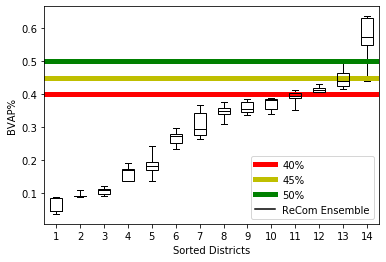

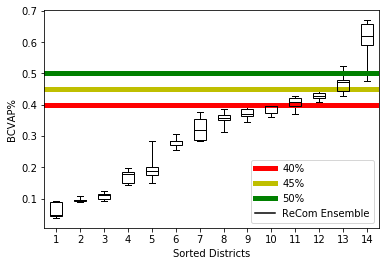

In [94]:
# PLOT SORTED DISTRICTS OVER BVAP %

c='k'

#37 to 55 is opportunity district BVAP range in VA

plt.figure()
plt.boxplot(
            np.array(BVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

#plt.plot([1,2,3,4,5,6,7],[.233,.268,.268,.297,.322,.337,.621], 'o', color="hotpink", label="Enacted",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BVAP%")

plt.legend()

plt.show()


# PLOT SORTED DISTRICTS OVER CBVAP %

plt.figure()
plt.boxplot(
            np.array(BCVAPS[0]),
            whis=[1, 99],
            showfliers=False,
            patch_artist=True,
            boxprops=dict(facecolor="None", color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)

#plt.plot([1,2,3,4,5,6,7],[.233,.268,.268,.297,.322,.337,.621], 'o', color="hotpink", label="Enacted",markersize=10)

plt.axhline(y=.4,color='r',label="40%",linewidth=5)

plt.axhline(y=.45,color='y',label="45%",linewidth=5)

plt.axhline(y=.5,color='g',label="50%",linewidth=5)
plt.plot([],[],color='k',label="ReCom Ensemble")
plt.xlabel("Sorted Districts")
plt.ylabel("BCVAP%")

plt.legend()

plt.show()